<div style="float:left">
    <h1 style="width:750px">CASA 0013 Foundation of Spatial Data Science</h1>
    <h2 style="width:750px">Assessment 3: Reproducible Analysis</h2>
    <h2 style="width:750px">Student ID：20088234</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

## 1.Import Data


* The research hopes to investigate, in typical tourism hotspot areas of London, which key terms are used for marketing Airbnb listings.
* The research can be divided into two sub-questions: first, how to identify the different tourism hotspot areas in London; second, how to detect and analyse the key terms used in marketing listings.
* Airbnb listing data, Point of Interest data and MSOA data are needed

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os


In [2]:
# Import the Airbnb Data
url_listings = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz'
listings = pd.read_csv(url_listings, compression='gzip', low_memory=False)
# Print the shape of the dataset
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 67,903 x 74


In [3]:
# Convert listings as points whose crs = EPSG 27700
listings_points = gpd.GeoDataFrame(listings, 
      geometry=gpd.points_from_xy(listings['longitude'], listings['latitude'], crs='epsg:4326'))
listings_points = listings_points.to_crs('epsg:27700')

In [4]:
# Import the MSOAs Data
# EPSG 27700
url_MSOA = 'https://github.com/fzc961020/fsds_task3/blob/main/London_msoa.gpkg?raw=true'
msoa = gpd.read_file(url_MSOA)
print(f"Data frame is {msoa.shape[0]:,} x {msoa.shape[1]}")
msoa.sample(5)

Data frame is 983 x 13


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


MSOA11CD        MSOA11NM    LAD11CD     LAD11NM    RGN11CD RGN11NM  \
62   E02000064      Barnet 041  E09000003      Barnet  E12000007  London   
437  E02000455      Harrow 023  E09000015      Harrow  E12000007  London   
486  E02000506  Hillingdon 013  E09000017  Hillingdon  E12000007  London   
698  E02000723      Newham 010  E09000025      Newham  E12000007  London   
344  E02000359     Hackney 015  E09000012     Hackney  E12000007  London   

     UsualRes  HholdRes  ComEstRes  PopDen  Hholds  AvHholdSz  \
62       6248      6016        232    78.7    2450        2.5   
437      8135      8050         85    66.1    3306        2.4   
486      7541      7455         86    13.7    2725        2.7   
698     10600     10591          9   149.3    2737        3.9   
344      6581      6569         12   150.7    2416        2.7   

                                              geometry  
62   MULTIPOLYGON (((524636.043 186894.204, 524733....  
437  MULTIPOLYGON (((516081.621 187992.794, 516044....  
486  MULTIPOLYGON (((506443.830 185991.564, 506492....  
698  MULTIPOLYGON (((542623.235 184895.329, 542646....  
344  MULTIPOLYGON (((535763.988 185980.341, 535772....

In [5]:
# Drop columns that may not be used in this research
msoa = msoa.drop(columns=['LAD11CD','LAD11NM','RGN11CD','RGN11NM','UsualRes','HholdRes','ComEstRes','PopDen','AvHholdSz'])

In [6]:
# Import the poi Data
# From EPSG 4326 to EPSG 27700
url_poi = 'https://github.com/fzc961020/fsds_task3/blob/main/London_poi.gpkg?raw=true'
poi = gpd.read_file(url_poi)
poi = poi.to_crs('epsg:27700')
print(f"Data frame is {poi.shape[0]:,} x {poi.shape[1]}")

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Data frame is 66,257 x 5



## 2.Data Cleaning

* The research plans to use clustering method to identify different tourist hotspots with independent characteristics in the Great London area. Then, identify the key terms in listings description in selected areas.
* To meet the requirement, preliminary data cleaning and dimensionality reduction are performed for different types of data

### 2.1 POI data

#### 2.1.1 Toursim related attributes selection

<AxesSubplot:>

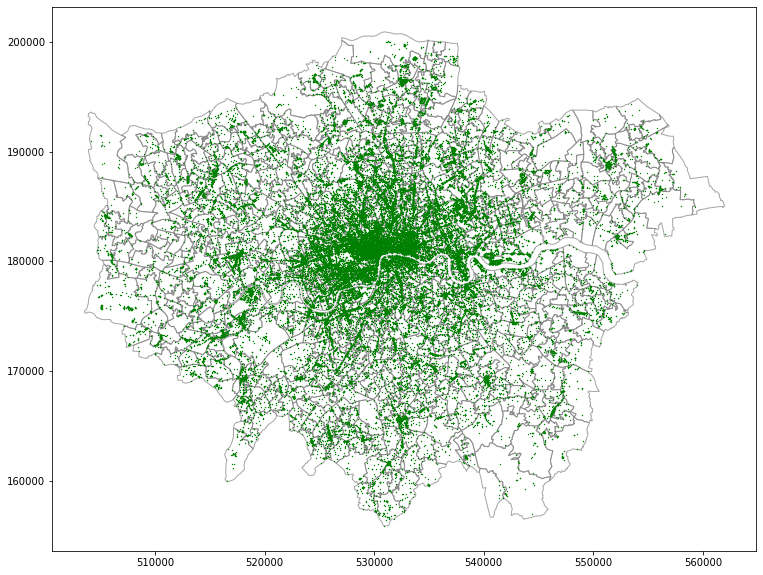

In [7]:
# Use spatial join to subset only the points within the Great london Boundary
poi_msoas = gpd.sjoin(poi,msoa, op='intersects')
ax = msoa.plot(figsize=(15,10),edgecolor='grey', facecolor='None', alpha=0.7)
poi_msoas.plot(ax=ax, marker='*', color='green', markersize=0.25)

In [8]:
# check the column name and number of the dataset 
poi_msoas.sample(5)

osm_id  code     fclass                                name  \
52021  6386858905  2302  fast_food                            Domino's   
38774  4382385826  2902      bench                                None   
27099  3021028943  2902      bench                                None   
41528  4691563239  2519   optician  The Anglo American Optical Company   
2836    269070086  2004   post_box                                None   

                            geometry  index_right   MSOA11CD      MSOA11NM  \
52021  POINT (546138.352 166046.199)          149  E02000154   Bromley 028   
38774  POINT (537980.254 184114.939)          701  E02000726    Newham 013   
27099  POINT (532457.961 198482.739)          272  E02000280   Enfield 004   
41528  POINT (528908.489 187750.061)          415  E02000431  Haringey 035   
2836   POINT (526437.285 162623.628)          830  E02000861    Sutton 022   

       Hholds  
52021    3293  
38774    3666  
27099    3466  
41528    3133  
2836     2789

In [9]:
# check and delete the observation with null name
print(poi_msoas.name.isnull().count())

65950


In [10]:
poi_msoas.drop(poi_msoas[poi_msoas.name.isnull()].index.values, axis=0, inplace=True)

In [11]:
# summary the count of different types in tourism type
poi_msoas.fclass.value_counts()[:50]

restaurant           4340
cafe                 3083
fast_food            2549
convenience          2112
pub                  1690
clothes              1661
hairdresser          1650
memorial             1607
beauty_shop           809
bicycle_rental        797
pharmacy              732
laundry               689
bar                   638
supermarket           592
bank                  563
artwork               522
dentist               380
newsagent             365
tourist_info          360
bakery                345
hotel                 321
jeweller              297
doityourself          292
shoe_shop             285
furniture_shop        273
doctors               271
post_office           264
mobile_phone_shop     260
optician              259
gift_shop             258
beverages             203
kindergarten          202
school                195
sports_centre         194
florist               187
bicycle_shop          181
butcher               173
monument              165
library     

In [12]:
# show all the keywords that define the poi types
poi_msoas.fclass.unique()

array(['convenience', 'pub', 'museum', 'cafe', 'attraction', 'florist',
       'bank', 'restaurant', 'fountain', 'bicycle_rental', 'car_rental',
       'fast_food', 'drinking_water', 'nightclub', 'artwork',
       'hairdresser', 'laundry', 'gift_shop', 'memorial', 'beauty_shop',
       'dentist', 'clothes', 'hotel', 'telephone', 'department_store',
       'newsagent', 'stationery', 'chemist', 'supermarket', 'post_office',
       'doityourself', 'cinema', 'travel_agent', 'bookshop', 'pharmacy',
       'bakery', 'optician', 'outdoor_shop', 'car_dealership', 'bar',
       'park', 'university', 'sports_centre', 'hostel', 'kindergarten',
       'furniture_shop', 'library', 'shoe_shop', 'garden_centre',
       'school', 'guesthouse', 'college', 'tourist_info', 'doctors',
       'community_centre', 'bicycle_shop', 'arts_centre', 'courthouse',
       'veterinary', 'car_wash', 'mobile_phone_shop', 'monument',
       'sports_shop', 'ruins', 'beverages', 'jeweller', 'computer_shop',
       'publi

In [13]:
# Select key words that may be related with tourism activities
tourism_keywords = ['pub', 'museum', 'cafe', 'attraction', 'restaurant', 'fountain','fast_food', 'nightclub',
                    'artwork', 'gift_shop', 'memorial',  'cinema', 'travel_agent', 'bar','park', 'garden_centre', 
                    'tourist_info', 'arts_centre', 'monument','theatre', 'viewpoint', 'mall','toy_shop',  'theme_park',
                    'zoo', 'camp_site']

In [14]:
# summarize the count of different types in keywords
poi_msoas_select = poi_msoas[["name","fclass","MSOA11CD","geometry"]]
poi_msoas_select_1 = poi_msoas_select[poi_msoas_select.fclass.isin(tourism_keywords)]
poi_msoas_select_1.fclass.value_counts()

restaurant       4340
cafe             3083
fast_food        2549
pub              1690
memorial         1607
bar               638
artwork           522
tourist_info      360
gift_shop         258
monument          165
travel_agent      154
attraction        114
nightclub          94
museum             83
theatre            79
cinema             72
toy_shop           47
arts_centre        36
viewpoint          22
garden_centre      22
fountain           20
park               17
mall                7
theme_park          1
zoo                 1
camp_site           1
Name: fclass, dtype: int64

In [15]:
# According to the theme and count difference, several categories of keywords are further selected : food_drink & art_culture
# Most of the key words in each category have over 100 points

food_drink = ["restaurant","cafe","fast_food","pub","bar","nightclub"]
art_culture =  ["memorial","artwork","monument","attraction","museum","theatre"]

In [16]:
# Groupby and summarize the count of different keyword types in different msoa units
poi_msoas_select_2 = poi_msoas_select_1.groupby('MSOA11CD')['fclass'].value_counts()
poi_msoas_select_3 = poi_msoas_select_2.to_frame(name = "count").reset_index()
poi_msoas_select_3

MSOA11CD        fclass  count
0     E02000001    restaurant    193
1     E02000001          cafe    138
2     E02000001     fast_food    134
3     E02000001      memorial     90
4     E02000001           bar     80
...         ...           ...    ...
3962  E02006931  tourist_info      2
3963  E02006931    attraction      1
3964  E02006931      monument      1
3965  E02006931       theatre      1
3966  E02006931      toy_shop      1

[3967 rows x 3 columns]

In [17]:
# the total msoa count should be 983
# some of the msoa units don't have points
# which may cause no match when merging dataframe

len(poi_msoas_select_1.MSOA11CD.unique())

910

In [18]:
# use pivot_table to convert the dataframe as 'wider'
poi_msoas_select_4 = poi_msoas_select_3.pivot_table(index='MSOA11CD', columns='fclass', values='count',fill_value = 0).reset_index()


In [19]:
# join other all 0 msoa units back
msoa_code = msoa['MSOA11CD']
poi_msoas_select_5 = pd.merge(poi_msoas_select_4,msoa_code,left_on = 'MSOA11CD', right_on ='MSOA11CD',how='outer').fillna(0)
poi_msoas_select_5.sample(5)

MSOA11CD  arts_centre  artwork  attraction  bar  cafe  camp_site  \
902  E02006918          0.0      1.0         0.0  0.0   1.0        0.0   
563  E02000640          0.0      0.0         0.0  0.0   0.0        0.0   
845  E02000947          0.0      0.0         0.0  0.0   1.0        0.0   
339  E02000393          0.0      0.0         0.0  0.0   4.0        0.0   
291  E02000343          0.0      0.0         0.0  0.0   1.0        0.0   

     cinema  fast_food  fountain  ...  park  pub  restaurant  theatre  \
902     0.0        0.0       0.0  ...   0.0  1.0         0.0      0.0   
563     0.0        0.0       0.0  ...   0.0  0.0         2.0      0.0   
845     0.0        0.0       0.0  ...   0.0  3.0         0.0      0.0   
339     0.0        0.0       0.0  ...   0.0  0.0         0.0      0.0   
291     0.0        0.0       0.0  ...   0.0  0.0         1.0      0.0   

     theme_park  tourist_info  toy_shop  travel_agent  viewpoint  zoo  
902         0.0           1.0       0.0           0.0        0.0  0.0  
563         0.0           0.0       0.0           0.0        0.0  0.0  
845         0.0           0.0       0.0           0.0        0.0  0.0  
339         0.0           0.0       0.0           0.0        0.0  0.0  
291         0.0           0.0       0.0           0.0        0.0  0.0  

[5 rows x 27 columns]

In [20]:
poi_cldf = poi_msoas_select_5.drop(columns =["MSOA11CD"])
poi_cldf

arts_centre  artwork  attraction   bar   cafe  camp_site  cinema  \
0            0.0     52.0         6.0  80.0  138.0        0.0     3.0   
1            0.0      0.0         1.0   0.0    0.0        0.0     0.0   
2            0.0      0.0         0.0   0.0    0.0        0.0     0.0   
3            0.0      1.0         0.0   0.0    0.0        0.0     0.0   
4            0.0      0.0         0.0   0.0    1.0        0.0     0.0   
..           ...      ...         ...   ...    ...        ...     ...   
978          0.0      0.0         0.0   0.0    0.0        0.0     0.0   
979          0.0      0.0         0.0   0.0    0.0        0.0     0.0   
980          0.0      0.0         0.0   0.0    0.0        0.0     0.0   
981          0.0      0.0         0.0   0.0    0.0        0.0     0.0   
982          0.0      0.0         0.0   0.0    0.0        0.0     0.0   

     fast_food  fountain  garden_centre  ...  park   pub  restaurant  theatre  \
0        134.0       2.0            0.0  ...   0.0  77.0       193.0      3.0   
1          0.0       0.0            1.0  ...   0.0   2.0         0.0      0.0   
2          1.0       0.0            0.0  ...   0.0   1.0         0.0      0.0   
3          0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
4          0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
..         ...       ...            ...  ...   ...   ...         ...      ...   
978        0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
979        0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
980        0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
981        0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   
982        0.0       0.0            0.0  ...   0.0   0.0         0.0      0.0   

     theme_park  tourist_info  toy_shop  travel_agent  viewpoint  zoo  
0           0.0           4.0       0.0           2.0        1.0  0.0  
1           0.0           0.0       0.0           0.0        0.0  0.0  
2           0.0           0.0       0.0           0.0        0.0  0.0  
3           0.0          11.0       0.0           0.0        0.0  0.0  
4           0.0           0.0       0.0           0.0        0.0  0.0  
..          ...           ...       ...           ...        ...  ...  
978         0.0           0.0       0.0           0.0        0.0  0.0  
979         0.0           0.0       0.0           0.0        0.0  0.0  
980         0.0           0.0       0.0           0.0        0.0  0.0  
981         0.0           0.0       0.0           0.0        0.0  0.0  
982         0.0           0.0       0.0           0.0        0.0  0.0  

[983 rows x 26 columns]

#### 2.1.2 POI Data : Dimension Reduction

* Considering that there are 12 attributes in art-culture and food-drink topics, which are still too much for clustering analysis
* Use PCA to reduce the dimension

In [21]:
# Import libraries about PCA and clustering
import sklearn
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

rbs = RobustScaler(quantile_range=[0.25,0.75])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer(method="yeo-johnson")

In [22]:
# Rescale the columns using the MinMaxScaler set up in the Preamble
for c in poi_cldf.columns:
    poi_cldf[c] = mms.fit_transform(poi_cldf[c].values.reshape(-1,1))

# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation

# Check output
poi_cldf.head(2)

arts_centre  artwork  attraction   bar  cafe  camp_site  cinema  fast_food  \
0        -1.00     1.00        0.33  1.00  1.00      -1.00   -0.25       1.00   
1        -1.00    -1.00       -0.78 -1.00 -1.00      -1.00   -1.00      -1.00   

   fountain  garden_centre  ...  park   pub  restaurant  theatre  theme_park  \
0      1.00          -1.00  ... -1.00  1.00        0.32     0.00       -1.00   
1     -1.00          -0.50  ... -1.00 -0.95       -1.00    -1.00       -1.00   

   tourist_info  toy_shop  travel_agent  viewpoint   zoo  
0         -0.71     -1.00         -0.43       0.00 -1.00  
1         -1.00     -1.00         -1.00      -1.00 -1.00  

[2 rows x 26 columns]

In [23]:
# Select the two subset with the keywords in two categories
food_drink_cldf = poi_cldf[food_drink]
art_culture_cldf = poi_cldf[art_culture]

In [24]:
# PCA ANALYSIS 
from sklearn.decomposition import PCA 

pca = PCA(n_components=5, whiten=True) 

pca.fit(food_drink_cldf)

X_food_drink = pca.fit_transform(food_drink_cldf)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_


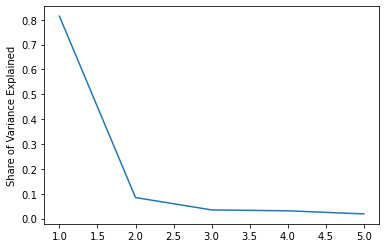

In [25]:
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [26]:
for i in range(0, 5):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 81.42% of variance
Component  1 accounts for 8.49% of variance
Component  2 accounts for 3.52% of variance
Component  3 accounts for 3.16% of variance
Component  4 accounts for 1.91% of variance


In [27]:
# original_num_df the original numeric dataframe
# pca is the model
def create_importance_dataframe(pca, original_num_df):

    # Change pcs components ndarray to a dataframe
    importance_df  = pd.DataFrame(pca.components_)

    # Assign columns
    importance_df.columns  = original_num_df.columns

    # Change to absolute values
    importance_df =importance_df.apply(np.abs)

    # Transpose
    importance_df=importance_df.transpose()

    # Change column names again

    ## First get number of pcs
    num_pcs = importance_df.shape[1]

    ## Generate the new column names
    new_columns = [f'PC{i}' for i in range(1, num_pcs + 1)]

    ## Now rename
    importance_df.columns  =new_columns

    # Return importance df
    return importance_df


In [28]:
# Call function to create importance df
importance_df  =create_importance_dataframe(pca, food_drink_cldf)

# Show first few rows
display(importance_df.head(10))


PC1  PC2  PC3  PC4  PC5
restaurant 0.45 0.27 0.02 0.64 0.18
cafe       0.50 0.10 0.30 0.34 0.25
fast_food  0.42 0.21 0.58 0.49 0.17
pub        0.37 0.53 0.69 0.08 0.29
bar        0.41 0.06 0.16 0.34 0.79
nightclub  0.25 0.77 0.26 0.34 0.41

In [29]:
# PCA ANALYSIS 
from sklearn.decomposition import PCA 

pca = PCA(n_components=5, whiten=True) 

pca.fit(art_culture_cldf)

X_art_culture = pca.fit_transform(art_culture_cldf)

explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_


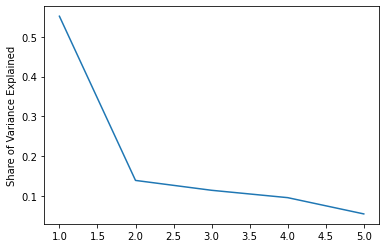

In [30]:
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

In [31]:
for i in range(0, 5):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 55.15% of variance
Component  1 accounts for 13.93% of variance
Component  2 accounts for 11.45% of variance
Component  3 accounts for 9.60% of variance
Component  4 accounts for 5.52% of variance


In [32]:
# Call function to create importance df
importance_df  =create_importance_dataframe(pca, art_culture_cldf)

# Show first few rows
display(importance_df.head(10))

PC1  PC2  PC3  PC4  PC5
memorial   0.45 0.20 0.21 0.44 0.17
artwork    0.31 0.02 0.23 0.42 0.74
monument   0.25 0.01 0.26 0.32 0.65
attraction 0.43 0.66 0.39 0.46 0.03
museum     0.57 0.60 0.18 0.51 0.02
theatre    0.37 0.40 0.81 0.23 0.04

In [33]:
# select component 1 in food_drink and component 1,2,3 in art_culture as the features standing for the tourism attraction.

keep_n_components= 1

for x in [X_food_drink]:
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])

    for i in range(0,keep_n_components):
        poi_msoas_select_5[f"food_drink1"] = new_columns[i]

        
keep_n_components= 3

for x in [X_art_culture]:
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])

    for i in range(0,keep_n_components):
        poi_msoas_select_5[f"art_culture{i+1}"] = new_columns[i]


In [34]:
# check the shape and column of the final attributes from Poi data
pcadf = pd.merge(msoa, poi_msoas_select_5,left_on='MSOA11CD', right_on='MSOA11CD',how='outer')
pcadf = pcadf[["MSOA11CD","geometry","food_drink1","art_culture1","art_culture2","art_culture3"]]
print(f"PCA df has shape {pcadf.shape[0]} x {pcadf.shape[1]}")
pcadf.sample(3)

PCA df has shape 983 x 6


MSOA11CD                                           geometry  \
810  E02000841  MULTIPOLYGON (((526809.185 166761.956, 526815....   
801  E02000832  MULTIPOLYGON (((535382.194 176270.363, 535479....   
813  E02000844  MULTIPOLYGON (((527329.557 166648.334, 527345....   

     food_drink1  art_culture1  art_culture2  art_culture3  
810        -0.12         -0.27         -0.01          0.03  
801        -0.15         -0.21         -0.07          0.11  
813         0.00         -0.19         -0.01          0.22

### 2.2 Airbnb Listings

#### 2.2.1 Attributes Selection

* Mainly select lisitng price, listing review per month and count itself as the attributes
* Some other important columns are also select to check the null value

In [35]:
# key columns such as id, longitude, latitude and room type don't have the null values
# review per month has 19028 null value, which is dropped in the following analysis

#listings_points.isnull().sum(axis=0).sort_values(ascending=False)[:50]
listings_points[["id","price","longitude","latitude","room_type","number_of_reviews","reviews_per_month","number_of_reviews_l30d","number_of_reviews_ltm"]].isnull().sum(axis=0).sort_values(ascending=False)[:50]

reviews_per_month         19028
id                            0
price                         0
longitude                     0
latitude                      0
room_type                     0
number_of_reviews             0
number_of_reviews_l30d        0
number_of_reviews_ltm         0
dtype: int64

In [36]:
# drop observations that has NaN in "reviews_per_month", the total review is zero.
listings_points.drop(listings_points[listings_points.reviews_per_month.isnull()].index.values, axis=0, inplace=True)

Data frame is 48,863 x 79


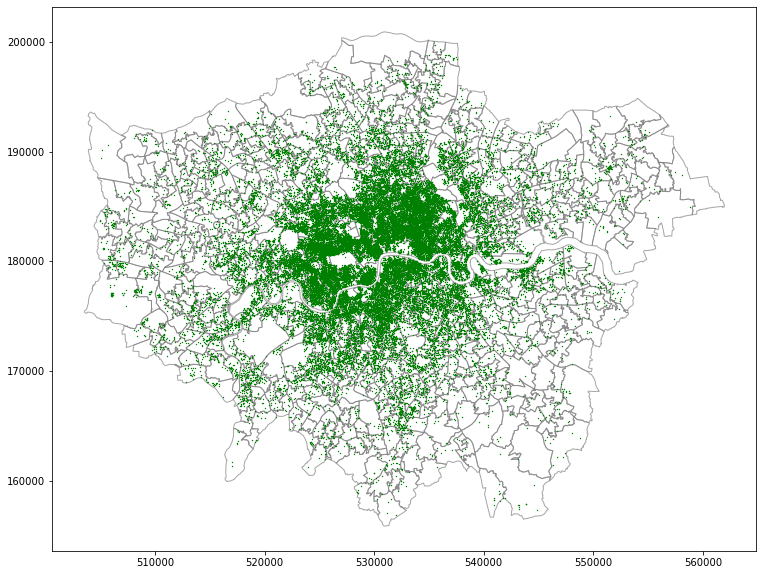

In [37]:
# Use spatail join to subset only the listing points within the Great london Boundary
listings_msoa = gpd.sjoin(listings_points,msoa, op='within')
ax = msoa.plot(figsize=(15,10),edgecolor='grey', facecolor='None', alpha=0.7)
listings_msoa.plot(ax=ax, marker='*', color='green', markersize=0.25)
print(f"Data frame is {listings_msoa.shape[0]:,} x {listings_msoa.shape[1]}")

In [38]:
# convert the price column from string to float
listings_msoa.price = listings_msoa.price.str.replace('$','').str.replace(',','').astype('float')

/tmp/ipykernel_599/1568099315.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings_msoa.price = listings_msoa.price.str.replace('$','').str.replace(',','').astype('float')


In [39]:
# Test if the price and count in different room types may vary greatly
listings_msoa_type_price = listings_msoa.groupby('room_type')['price'].median()
listings_msoa_type_count = listings_msoa.groupby('room_type')['id'].count()
listings_msoa_type_review_month = listings_msoa.groupby('room_type')["reviews_per_month"].median()


In [40]:
listings_msoa_type_price 

room_type
Entire home/apt   117.00
Hotel room        140.00
Private room       40.00
Shared room        30.00
Name: price, dtype: float64

In [41]:
listings_msoa_type_count

room_type
Entire home/apt    28536
Hotel room           276
Private room       19797
Shared room          254
Name: id, dtype: int64

In [42]:
listings_msoa_type_review_month

room_type
Entire home/apt   0.33
Hotel room        0.22
Private room      0.28
Shared room       0.21
Name: reviews_per_month, dtype: float64

In [43]:
# considering that the price and count are significantly different between entire home and private room,

# try only select the count and price of 'Entire home/apt' type listing to represent the difference across the msoa units.

# The rent price difference can further reflect the potential income level in local areas
# Summaryize the listing count in each MSOA unit.

listings_msoa_1 = listings_msoa[listings_msoa.room_type =='Entire home/apt'].groupby('MSOA11CD')['id'].count()
#listings_msoa_1 = listings_msoa.groupby('MSOA11CD')['id'].count()
listings_msoa_count = listings_msoa_1.to_frame(name = "listing_count").reset_index()
listings_msoa_count

listings_msoa_2 = listings_msoa[listings_msoa.room_type =='Entire home/apt'].groupby('MSOA11CD')["reviews_per_month"].median()
#listings_msoa_2 = listings_msoa.groupby('MSOA11CD')["reviews_per_month"].median()
listings_msoa_median_reviews_per_month = listings_msoa_2.to_frame(name = "median_reviews_per_month").reset_index()
listings_msoa_median_reviews_per_month

listings_msoa_3 = listings_msoa[listings_msoa.room_type =='Entire home/apt'].groupby('MSOA11CD')['price'].median()
listings_msoa_median_price = listings_msoa_3.to_frame(name = "median_price").reset_index()
listings_msoa_median_price

MSOA11CD  median_price
0    E02000001        150.00
1    E02000002        213.00
2    E02000003        115.00
3    E02000005        145.00
4    E02000007         84.50
..         ...           ...
929  E02006927         90.00
930  E02006928        115.00
931  E02006929        150.00
932  E02006930        145.50
933  E02006931         99.50

[934 rows x 2 columns]

In [44]:
# Join the listings and tourism data back to msoa units
data_merged1 = pd.merge(msoa,listings_msoa_count,on = 'MSOA11CD',how="outer")
data_merged2 = pd.merge(data_merged1,listings_msoa_median_price,on = 'MSOA11CD',how="outer")
data_merged3 = pd.merge(data_merged2,listings_msoa_median_reviews_per_month,on = 'MSOA11CD',how="outer")
data_merged3["listing_density"] = data_merged3.listing_count/data_merged3.Hholds
                        
data_merged4 = data_merged3[["MSOA11CD","median_price","median_reviews_per_month","listing_density"]]
listing_tourism = pd.merge(pcadf,data_merged4,on = 'MSOA11CD',how="outer").fillna(0)  

In [45]:
listing_tourism.sample(5)

MSOA11CD                                           geometry  \
256  E02000263  MULTIPOLYGON (((512492.807 180573.391, 512508....   
352  E02000367  MULTIPOLYGON (((534946.250 184544.031, 534952....   
298  E02000306  MULTIPOLYGON (((534709.110 193781.980, 534681....   
581  E02000602  MULTIPOLYGON (((519584.531 169416.449, 519644....   
90   E02000093  MULTIPOLYGON (((520173.611 190393.852, 520390....   

     food_drink1  art_culture1  art_culture2  art_culture3  median_price  \
256        -0.33         -0.27         -0.01          0.03          0.00   
352         0.42          0.72         -2.11         -0.66        100.00   
298        -0.13         -0.27         -0.01          0.03         70.00   
581        -0.16          0.72         -2.11         -0.66        105.00   
90         -0.20         -0.27         -0.01          0.03         95.00   

     median_reviews_per_month  listing_density  
256                      0.00             0.00  
352                      0.22             0.04  
298                      0.70             0.00  
581                      0.22             0.01  
90                       1.00             0.00

### 2.3 Data Visulisation

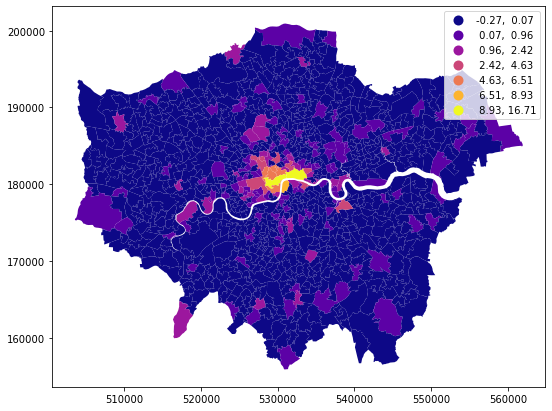

In [46]:
# art_culture1
listing_tourism.plot(column='art_culture1', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

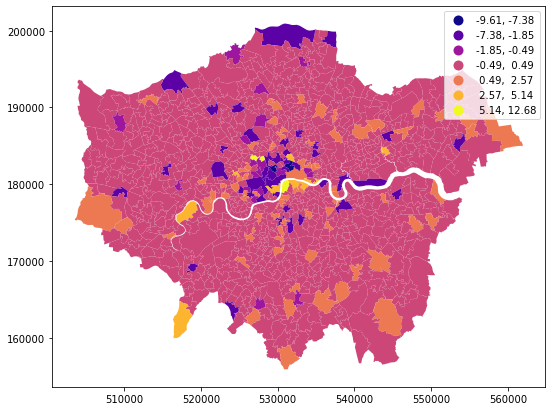

In [47]:
# art_culture2
listing_tourism.plot(column='art_culture2', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

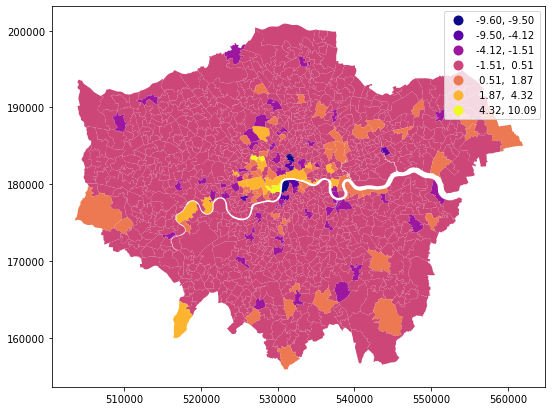

In [48]:
# art_culture3
listing_tourism.plot(column='art_culture3', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

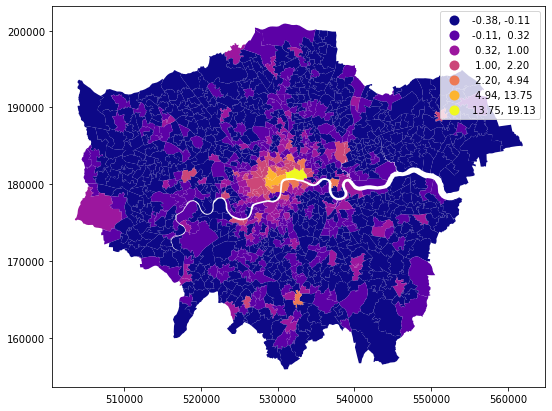

In [49]:
# food_drink1
listing_tourism.plot(column='food_drink1', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

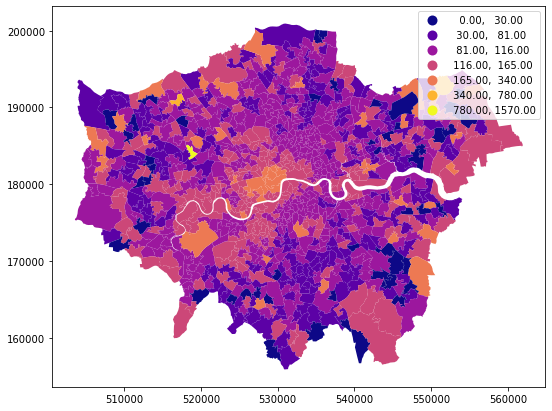

In [50]:
# median_price
listing_tourism.plot(column='median_price', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

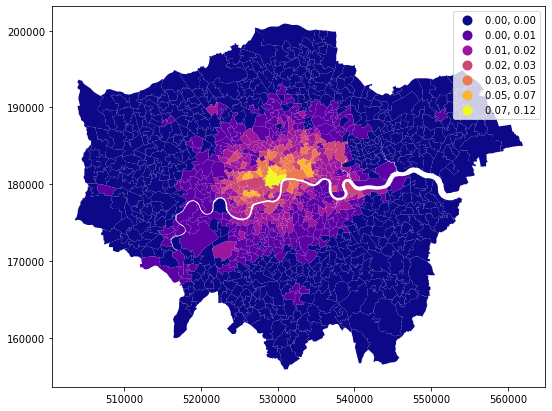

In [51]:
# listing_density
listing_tourism.plot(column='listing_density', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

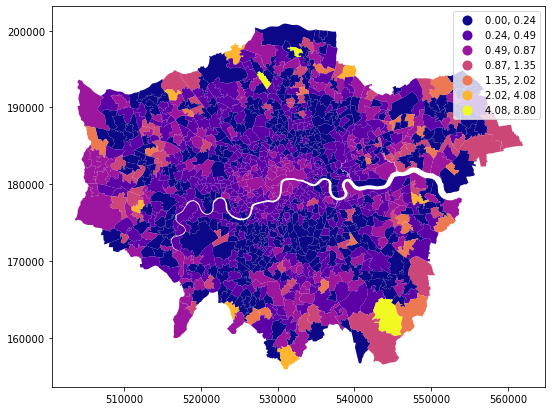

In [52]:
# median_reviews_per_month
listing_tourism.plot(column='median_reviews_per_month', cmap='plasma', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, figsize=(9,7));

## 3. Clustering Analysis

### 3.1 Data Normalization

In [53]:
# 下载数据
# 筛选MSOA里的数据
# 汇总不同类型的数量
# 挑出数量较多的几类
# 以msoa为组，分别汇总4种旅游相关点的数量，listing的数量，以及租金水平
# 尝试进行降维和聚类


In [54]:
def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [55]:
cldf = listing_tourism.drop(columns = ["geometry"]).set_index("MSOA11CD")
cldf
#sns.pairplot(cldf)

food_drink1  art_culture1  art_culture2  art_culture3  \
MSOA11CD                                                           
E02000001        19.13         13.26          1.75          4.13   
E02000002        -0.28          0.15          1.28          0.87   
E02000003        -0.30         -0.24         -0.04          0.07   
E02000004        -0.38         -0.19         -0.05          0.15   
E02000005        -0.38         -0.27         -0.01          0.03   
...                ...           ...           ...           ...   
E02006927        -0.33         -0.27         -0.01          0.03   
E02006928         0.04          0.30          1.12         -2.52   
E02006929         0.72          0.07         -0.09          0.57   
E02006930        -0.25         -0.27         -0.01          0.03   
E02006931         0.57          3.52         -2.21         -1.95   

           median_price  median_reviews_per_month  listing_density  
MSOA11CD                                                            
E02000001        150.00                      0.58             0.05  
E02000002        213.00                      0.35             0.00  
E02000003        115.00                      0.73             0.00  
E02000004          0.00                      0.00             0.00  
E02000005        145.00                      1.66             0.00  
...                 ...                       ...              ...  
E02006927         90.00                      0.22             0.00  
E02006928        115.00                      0.40             0.01  
E02006929        150.00                      0.57             0.02  
E02006930        145.50                      0.38             0.02  
E02006931         99.50                      0.30             0.01  

[983 rows x 7 columns]

In [56]:
# Rescale the columns using the MinMaxScaler set up in the Preamble

#for c in ["food_drink1","art_culture1","median_price","median_reviews_per_month","listing_density"]:
    #cldf[c] = pts.fit_transform(cldf[c].values.reshape(-1,1))
for c in cldf.columns:
    cldf[c] = rbs.fit_transform(cldf[c].values.reshape(-1,1))
for c in cldf.columns:
    cldf[c] = mms.fit_transform(cldf[c].values.reshape(-1,1))

In [57]:
# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation
rs   = pd.merge(msoa, cldf, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')
rs = rs.drop(columns = ["MSOA11NM","Hholds"])
# Check output
cldf.head(2)

food_drink1  art_culture1  art_culture2  art_culture3  \
MSOA11CD                                                           
E02000001         1.00          0.59          0.02          0.40   
E02000002        -0.99         -0.95         -0.02          0.06   

           median_price  median_reviews_per_month  listing_density  
MSOA11CD                                                            
E02000001         -0.81                     -0.87            -0.19  
E02000002         -0.73                     -0.92            -0.99

## 3.2 Kmeans Clustering Analysis

In [58]:
c_nm   = 'KMeans'

.......................................
Largest silhouette score was 0.6134 for k=2


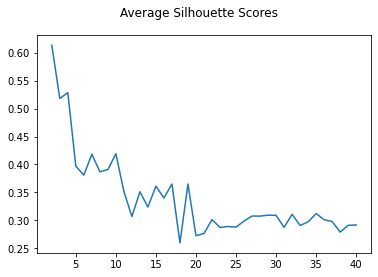

In [59]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores"); 

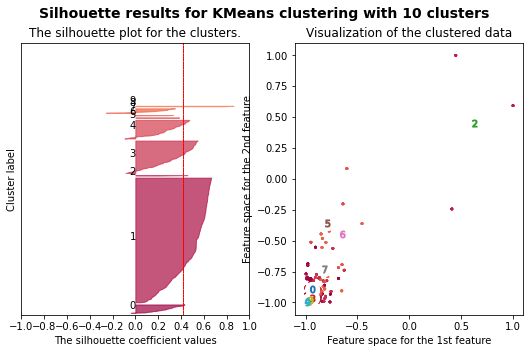

In [60]:
# set cluster number= 10
# when cluster number = 10, the average silhouette score has the second largest value

##### 
k_pref=10
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)

# We do this for plotting
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(cldf, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

In [61]:
rs.sample(5)

geometry  food_drink1  \
MSOA11CD                                                                    
E02000010  MULTIPOLYGON (((549618.850 185517.065, 549637....        -1.00   
E02000536  MULTIPOLYGON (((513056.000 177555.000, 513057....        -0.99   
E02000861  MULTIPOLYGON (((527495.197 163612.062, 527541....        -0.98   
E02000565  MULTIPOLYGON (((532536.608 185631.450, 532566....        -0.98   
E02000540  MULTIPOLYGON (((515026.647 176663.093, 514984....        -0.95   

           art_culture1  art_culture2  art_culture3  median_price  \
MSOA11CD                                                            
E02000010         -1.00         -0.14         -0.02         -0.86   
E02000536         -1.00         -0.14         -0.02         -0.91   
E02000861         -0.95         -0.02          0.06         -0.91   
E02000565         -0.99         -0.14         -0.01         -0.88   
E02000540         -1.00         -0.14         -0.02         -0.87   

           median_reviews_per_month  listing_density  KMeans  
MSOA11CD                                                      
E02000010                     -0.79            -0.97       4  
E02000536                     -0.96            -0.98       1  
E02000861                     -0.65            -0.98       4  
E02000565                     -0.95            -0.66       3  
E02000540                     -0.93            -0.93       1

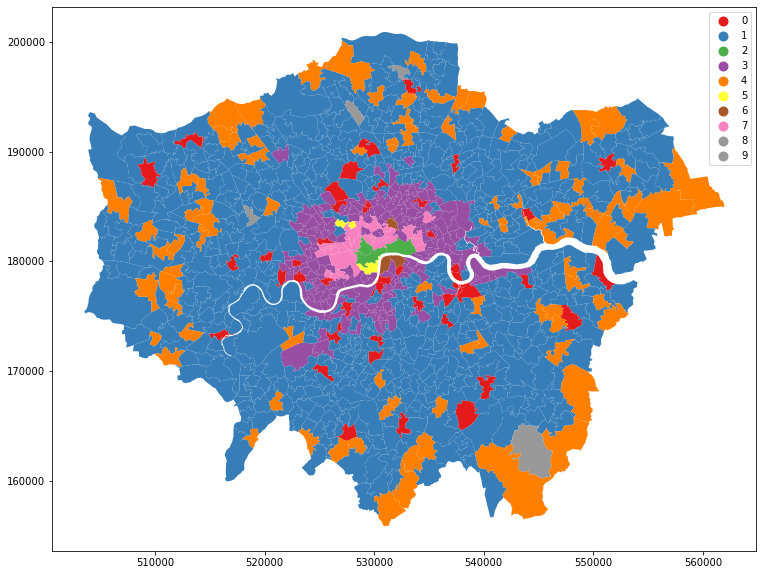

In [62]:
rs.plot(column=c_nm, linewidth=0, zorder=0, categorical=True,  cmap='Set1',legend=True,figsize=(15,10)); 

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4
Processing cluster 5
Processing cluster 6
Processing cluster 7
Processing cluster 8
Processing cluster 9


/tmp/ipykernel_599/2333928547.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroids = centroids.append(c.mean(), ignore_index=True)


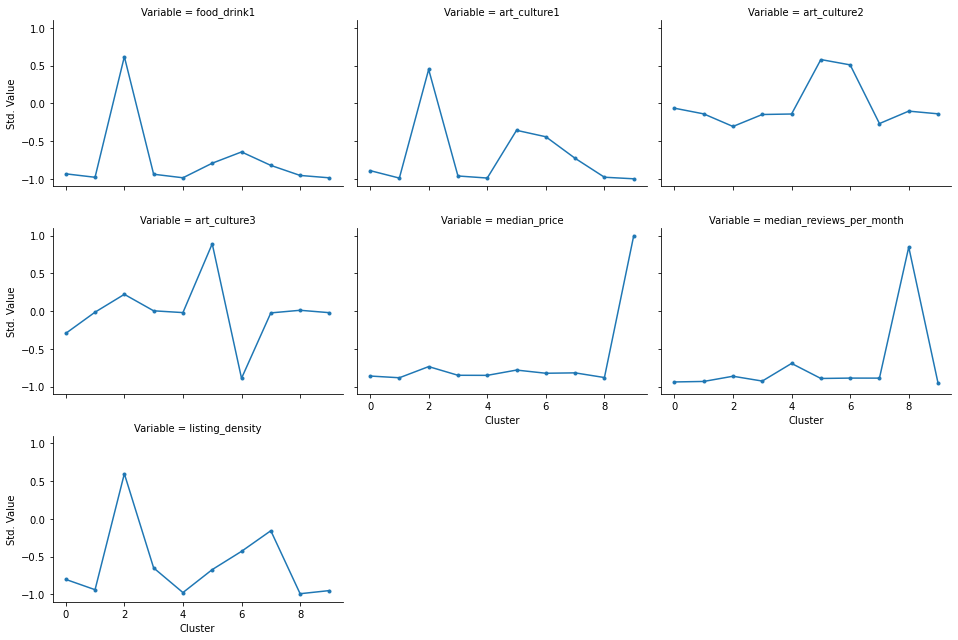

In [63]:
# draw the representative centroid for different clusters
centroids = None
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")

    c = rs[rs[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['Borough','msoa11hclnm','Subregion','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")


In [64]:
# The count and spatial distribution of different clusters are presented in the figure. 
# In general, the central London area has more clustering categories and fewer samples, while the constitution of clusters in suburban areas is relatively single. 
# Further comparison of representative centroids shows that clusters2, clusters5 and clusters6 have outstanding characteristics. 
# Cluster2 includes the main areas of the City and Westminster, which can be regarded as the most important tourist hot spots in London. 
# The standard values of fooddrink1, artculture1 and listing density are the highest for the cluster 2 listings. The standard value of density is the highest. 
# Clusters5 and clusters6 represent sub hot spots for tourism activities, whose main parts are located on the north and south bank of the River Thames, respectively. 
# There are similar properties in cluster5 and cluster6, including the highest standard value of artcultre2, and relatively higher fooddrink1 and artculture1. 
# The difference is that cluster5 is significantly higher than cluster6 in artculture 3, highlighting the characteristics of theatre count.

In [65]:
# Join the cluster information to the listing-Msoa data and get the corresponding description attribute.

In [66]:
rs_MSOA_KMeans = rs[["KMeans"]]
rs_MSOA_KMeans_listings = pd.merge( listings_msoa,rs_MSOA_KMeans,on='MSOA11CD',how = 'outer')

In [67]:
rs_MSOA_KMeans_listings[["description","amenities"]].isnull().sum(axis=0).sort_values(ascending=False)[:50]

description    1029
amenities         5
dtype: int64

In [68]:
rs_MSOA_KMeans_listings.drop(rs_MSOA_KMeans_listings[rs_MSOA_KMeans_listings.description.isnull()].index.values, axis=0, inplace=True)

In [69]:
text_keywords = ["id","description","amenities","MSOA11CD","MSOA11NM","KMeans","price","reviews_per_month"]
all_listings_description =rs_MSOA_KMeans_listings[text_keywords]
all_listings_description.sample()

id                                        description  \
29892 27,808,610.00  3 bedroom house with garden ,quite area oposit...   

                                               amenities   MSOA11CD  \
29892  ["Heating", "Shower gel", "Dishes and silverwa...  E02000822   

            MSOA11NM  KMeans  price  reviews_per_month  
29892  Southwark 016       1  30.00               2.38

In [70]:
# Regroup the msoa units and the corresponding listings points as the following groups.

# group1: all MSOA units in clustering 2,  as  ['Westminster 013', 'City of London 001', 'Westminster 018']. ['E02000972', 'E02000001', 'E02000977']
# group2: MSOA units in clustering 6 and in south bank, ['Lambeth 036', 'Southwark 002'] [ 'E02006801', 'E02000808'] 
# group3: MSOA units in clustering 5 and near Thames River, ['Westminster 020'] [ 'E02000979'] 
# group4: all MSOA units in clustering 7
# group5: all MSOA units in clustering 1

all_listings_description["groups"] = 0
all_listings_description.loc[all_listings_description.KMeans.isin([2]), ["groups"]] = 1
all_listings_description.loc[all_listings_description.MSOA11NM.isin(['Lambeth 036', 'Southwark 002']),["groups"]] = 2
all_listings_description.loc[all_listings_description.MSOA11NM.isin( ['Westminster 020']),["groups"]] = 3
all_listings_description.loc[all_listings_description.KMeans.isin([7]),["groups"]] = 4
all_listings_description.loc[all_listings_description.KMeans.isin([1]),["groups"]] = 5

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [71]:
len(rs_MSOA_KMeans_listings.MSOA11CD.unique())

978

In [72]:
all_listings_description.groups.unique()
all_listings_description.sample()

id                                        description  \
10865 16,724,241.00  A nice cozy private room in Pimlico, Central L...   

                                               amenities   MSOA11CD  \
10865  ["Hot water", "TV", "Wifi", "Smoke alarm", "Ki...  E02000981   

              MSOA11NM  KMeans  price  reviews_per_month  groups  
10865  Westminster 022       3  50.00               1.16       0

In [73]:
all_listings_description

id                                        description  \
0         13,913.00  My bright double bedroom with a large window h...   
1         89,870.00  My comfortable & bright one bedroom flat has a...   
2        411,961.00  This bright, spacious flat occupies two floors...   
3        958,304.00  Available for 3 weeks during April. Perfect fo...   
4        993,428.00  Large comfortable twin-bed room with private b...   
...             ...                                                ...   
48858 52,343,493.00  We offer a lovely new spacious double room, wi...   
48859 48,378,329.00  Cosy one bed apartment, offering complete priv...   
48860 50,866,061.00  Amazing newly refurbished 3 bedroom House with...   
48861 52,090,728.00  This stylish place to stay is perfect for solo...   
48862 51,320,831.00  A unique and beautiful camping pod ideal for a...   

                                               amenities   MSOA11CD  \
0      ["Pack \u2019n play/Travel crib", "Smoke alarm...  E02000556   
1      ["Pack \u2019n play/Travel crib", "Wine glasse...  E02000556   
2      ["Pack \u2019n play/Travel crib", "Smoke alarm...  E02000556   
3      ["Wifi", "Kitchen", "TV with standard cable", ...  E02000556   
4      ["Free street parking", "Hot water", "Wifi", "...  E02000556   
...                                                  ...        ...   
48858  ["Wine glasses", "Smoke alarm", "Shower gel", ...  E02000840   
48859  ["Mini fridge", "Portable fans", "Smoke alarm"...  E02000493   
48860  ["Pack \u2019n play/Travel crib", "Portable fa...  E02000493   
48861  ["Wine glasses", "Smoke alarm", "Free parking ...  E02000493   
48862  ["Mini fridge", "Portable fans", "Wine glasses...  E02000162   

            MSOA11NM  KMeans  price  reviews_per_month  groups  
0      Islington 003       0  65.00               0.17       0  
1      Islington 003       0 142.00               0.93       0  
2      Islington 003       0  80.00               0.07       0  
3      Islington 003       0 110.00               0.04       0  
4      Islington 003       0  67.00               1.22       0  
...              ...     ...    ...                ...     ...  
48858     Sutton 001       1  56.00               1.00       5  
48859   Havering 030       4 250.00               2.82       0  
48860   Havering 030       4 170.00               0.59       0  
48861   Havering 030       4  30.00               3.64       0  
48862    Bromley 036       8 123.00               8.80       0  

[47839 rows x 9 columns]

## 4. NLP

In [74]:
# Import the necessary libraries
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [75]:
# for machine learning
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [76]:
# for nltk
import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [77]:
# Download the script from CASA0013 FSDS module
# The raw file is saved on gitihub
import os
import requests


def download(url: str, dest_folder: str):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split('/')[-1].replace(" ", "_") 
    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))


download("https://raw.githubusercontent.com/fzc961020/fsds_task3/main/textual/__init__.py", dest_folder="textual")

# # Adapted from: https://stackoverflow.com/questions/56950987/download-file-from-url-and-save-it-in-a-folder-python/56951038


saving to /home/jovyan/work/MRES/CASA0013FSDS/textual/__init__.py


In [78]:
# load the script from CASA0013 FSDS module
%load_ext autoreload
%autoreload 2
import textual
from textual import *

/home/jovyan/work/MRES/CASA0013FSDS/textual/__init__.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if head is not '':
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [79]:
# Select group 1, group 2, group 3 and the correspnding listing description as the research objects 
# normlise the description document as 'description_norm'
all_listings_description = all_listings_description[all_listings_description.groups.isin([1,2,3])]
all_listings_description['description_norm'] = all_listings_description.description.apply(normalise_document)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [80]:
# normlise the description document, and select only the adj words from the text, as description_adj

all_listings_description['description_adj'] = all_listings_description.description.apply(normalise_document,text_lemmatization=False)
corpus = all_listings_description.description_adj.fillna(' ').values

# corpus is the list of 'sentence' 
# word_tokenize convert the sentence as the 'list of 'word' 
# pos_tag convert word as  (word, tag)

# convert single word in the list as (word, tag) in the list 
tagged_words_list = []
for i in corpus:
    
    words = word_tokenize(i)
    words_tagged = nltk.pos_tag(words)
    tagged_words_list.append(words_tagged)
    
# select only JJ,JJR,JJS 
adj_words_list = []
for n in tagged_words_list:
    list = []
    for m in n:
        if m[1] in ['JJ','JJR','JJS'] :
            list.append(m[0])
            
    adj_words_list.append(list)
    
# merge, and convert the words in the list as the same data structure as 'description_norm'
adj_sentence_list = []
for e in adj_words_list:
    a = ' '.join(e)
    adj_sentence_list.append(a)
    
all_listings_description['description_adj'] = adj_sentence_list


 Group1 

covent garden         131.68
living room           107.04
central london         93.48
minute walk            91.18
fully equip            87.28
walk distance          83.39
double bed             82.44
bedroom apartment      80.83
oxford street          78.39
sofa bed               74.19
open plan              72.77
leicester square       68.21
piccadilly circus      66.72
heart london           66.13
equip kitchen          63.49
one bedroom            59.27
west end               58.36
apartment locate       55.19
oxford circus          53.33
shower room            50.28
min walk               50.03
double bedroom         49.74
king size              49.73
two bedroom            49.19
underground station    48.81
dtype: float64

 Group2 

london eye          36.34
london bridge       35.25
minute walk         35.07
living room         30.53
borough market      29.37
central london      28.10
tate modern         26.78
double bed          26.00
big ben             25.93
doub

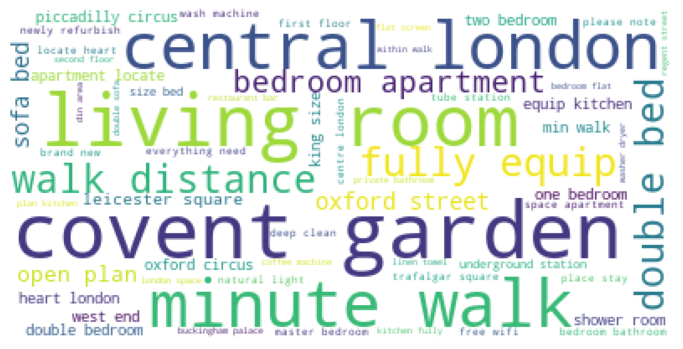

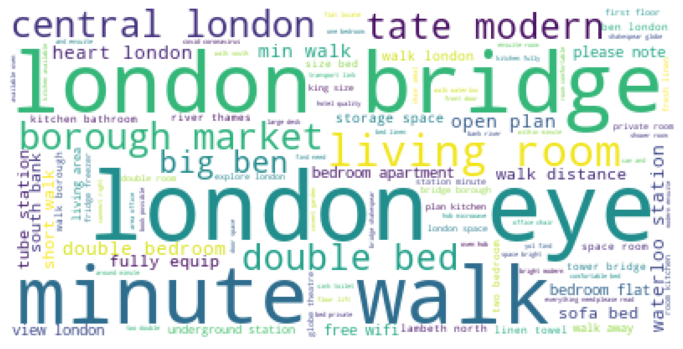

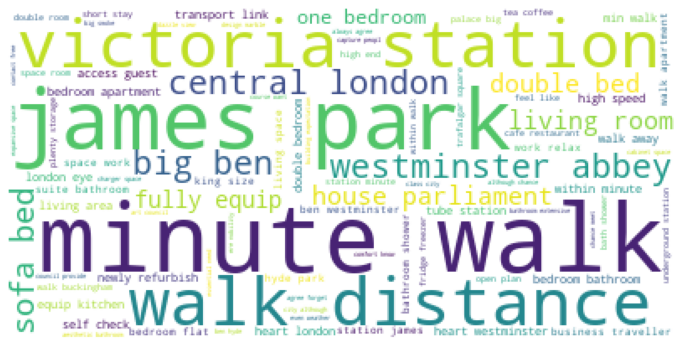

In [81]:
# calculate the tf-idf score for ngram = two terms
# and create word cloud
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(2,2), max_df=0.5, min_df=0.05)
for i in [1,2,3]:
    corpus = all_listings_description[all_listings_description.groups ==i].description_norm.fillna(' ').values
    tcorpus    = vectorizer.fit_transform(corpus)
    tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
    
    # here drop the fixed word in the list description
    tfidf = tfidf.drop(columns =['guest access','thing note'])
    if i ==1:
        g1_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group1').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g1_norm = tfidf
    if i ==2:
        g2_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group2').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g2_norm = tfidf
    if i ==3:      
        g3_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group3').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g3_norm = tfidf
    print(f"\n Group{i} \n")
    print(tfidf.sum().sort_values(ascending=False)[:25])
    plt.figure(figsize=(12, 12))
    Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(tfidf.sum())
    plt.imshow(Cloud) 
    plt.axis("off")


In [82]:
# select the first 20 words with highest tfidf scores in each group
# and find the common words in all three groups
# 8 2 gram words
combined_dictionary_norm = pd.merge(g1_dictionary[:20], g2_dictionary[:20], on = "keywords", how = 'outer').fillna(0)
combined_dictionary_norm = pd.merge(combined_dictionary_norm, g3_dictionary[:20], on = "keywords", how = 'outer').fillna(0)
common_dictionary_norm = combined_dictionary_norm[(combined_dictionary_norm.group1!=0) & (combined_dictionary_norm.group2!=0) & (combined_dictionary_norm.group3!=0)]
common_dictionary_norm

keywords  group1  group2  group3
1      living room  107.04   30.53    6.47
2   central london   93.48   28.10    8.21
3      minute walk   91.18   35.07   11.74
4      fully equip   87.28   17.05    6.36
5    walk distance   83.39   18.72    8.28
6       double bed   82.44   26.00    6.67
9         sofa bed   74.19   15.37    6.97
13    heart london   66.13   20.77    4.77


 Group1 

modern        114.98
large         103.90
private       102.88
spacious      101.21
perfect        78.15
comfortable    75.72
great          74.75
open           74.73
free           72.12
covent         70.80
oxford         70.03
high           69.93
new            67.86
best           64.66
quiet          64.30
beautiful      63.91
available      56.33
clean          55.30
single         52.72
square         52.58
short          52.04
easy           50.19
bright         50.00
famous         49.00
small          48.17
dtype: float64

 Group2 

modern        43.85
private       38.05
large         36.12
comfortable   29.99
spacious      29.71
big           28.55
free          28.49
perfect       25.46
open          23.55
quiet         23.43
available     22.80
great         22.54
new           22.14
short         21.05
high          20.79
south         20.72
underground   18.86
clean         18.68
right         18.20
ideal         18.07
beautiful     16.94
famous        16.7

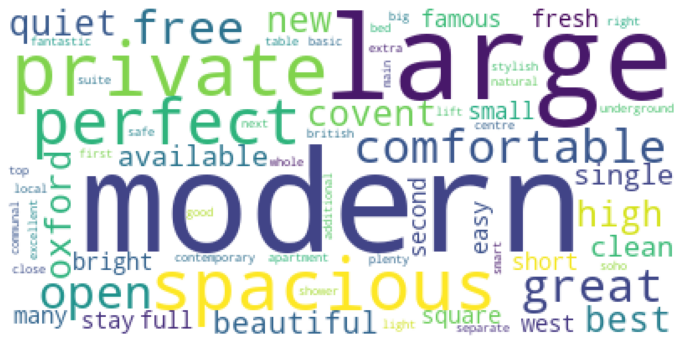

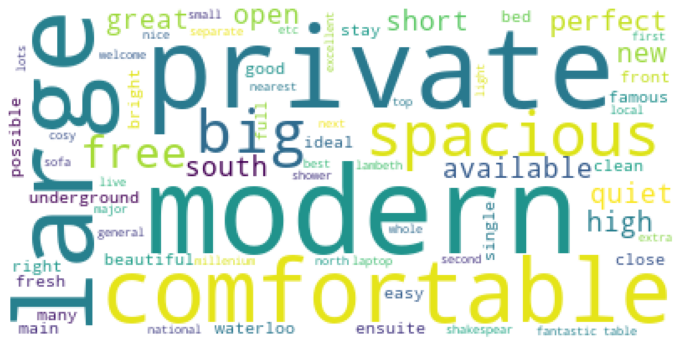

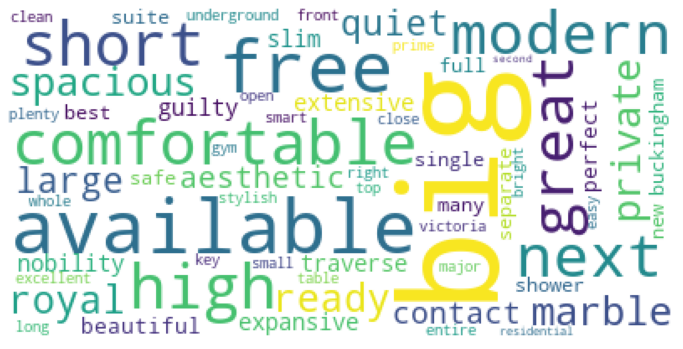

In [83]:
# calculate the tf-idf score for only adjective word
# and create word cloud

vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1), max_df=0.5, min_df=0.05)
for i in [1,2,3]:
    corpus = all_listings_description[all_listings_description.groups ==i].description_adj.fillna(' ').values
    tcorpus    = vectorizer.fit_transform(corpus)
    tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
    # delete the noun and frqency words that has appeared in the 2-gram words above
    tfidf = tfidf.drop(columns =['flat','central','london','double','guest'])

    if i ==1:
        g1_adj_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group1').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g1_adj = tfidf
    if i ==2:
        g2_adj_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group2').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g2_adj = tfidf
    if i ==3:      
        g3_adj_dictionary = tfidf.sum().sort_values(ascending=False).to_frame(name = 'group3').reset_index().rename(columns = {"index": "keywords"})
        tfidf_g3_adj = tfidf
    print(f"\n Group{i} \n")
    print(tfidf.sum().sort_values(ascending=False)[:25])
    plt.figure(figsize=(12, 12))
    Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(tfidf.sum())
    plt.imshow(Cloud) 
    plt.axis("off")


In [84]:
# select the first 15 words with highest tfidf scores in each group
# and find the common words in all three groups
# 8 adjective words
combined_dictionary_adj = pd.merge(g1_adj_dictionary[:15], g2_adj_dictionary[:15], on = "keywords", how = 'outer').fillna(0)
combined_dictionary_adj = pd.merge(combined_dictionary_adj, g3_adj_dictionary[:15], on = "keywords", how = 'outer').fillna(0)
common_dictionary_adj = combined_dictionary_adj[(combined_dictionary_adj.group1!=0) & (combined_dictionary_adj.group2!=0) & (combined_dictionary_adj.group3!=0)]
common_dictionary_adj

keywords  group1  group2  group3
0        modern  114.98   43.85    9.12
1         large  103.90   36.12    7.29
2       private  102.88   38.05    8.60
3      spacious  101.21   29.71    8.80
5   comfortable   75.72   29.99   10.23
6         great   74.75   22.54    9.07
8          free   72.12   28.49   11.93
11         high   69.93   20.79   10.04

In [85]:
# select four place name in each group with highest tf-idf score
# create a common word + place name dictionary for each group
common_dictionay_all = common_dictionary_norm.keywords.values.tolist() +  common_dictionary_adj.keywords.values.tolist()
common_dictionay_all

g1_place = ['covent garden','oxford street','leicester square','piccadilly circus']
# g1_charac_10 = ['living room','central london','minute walk','fully equip','walk distance','double bed','bedroom apartment','sofa bed','open plan','heart london']
# g1_charac_5 = ['living room','central london','minute walk','fully equip','walk distance']
# g1_adj = ['modern','large','private','spacious','perfect']
g1_dictionary = g1_place+common_dictionay_all

g2_place = ['london eye','london bridge','borough market','tate modern']
# g2_charac_10 = ['minute walk','living room','central london','double bed','double bedroom','min walk','heart london','open plan','walk distance','tube station']
# g2_charac_5 = ['minute walk','living room','central london','double bed','double bedroom']
# g2_adj = ['modern','private','large','comfortable','spacious']
g2_dictionary = g2_place + common_dictionay_all

g3_place = ['james park','victoria station','westminster abbey','big ben']
# g3_charac_10 = ['minute walk','walk distance','central london','sofa bed','double bed','living room','fully equip','one bedroom','bedroom apartment','tube station']
# g3_charac_5 = ['minute walk','walk distance','central london','sofa bed','double bed']
# g3_adj = ['big','available','free','comfortable','high'] 

g3_dictionary = g3_place + common_dictionay_all


In [86]:
# select the corresponding attributes from each group as independent variables

# to create a better fit model, try simplify tfidf score of words as "0" not appear in the description and "1" appear in the description

tfidf_g1_combined = pd.merge(tfidf_g1_adj,tfidf_g1_norm,left_index = True, right_index = True)[g1_dictionary]
tfidf_g2_combined = pd.merge(tfidf_g2_adj,tfidf_g2_norm,left_index = True, right_index = True)[g2_dictionary]
tfidf_g3_combined = pd.merge(tfidf_g3_adj,tfidf_g3_norm,left_index = True, right_index = True)[g3_dictionary]

tfidf_g3_0_1 = tfidf_g3_combined
tfidf_g2_0_1 = tfidf_g2_combined
tfidf_g1_0_1 = tfidf_g1_combined

for i in tfidf_g1_0_1.columns:
    tfidf_g1_0_1.loc[tfidf_g1_0_1[i]>0,[i]] = 1
for i in tfidf_g2_0_1.columns:
    tfidf_g2_0_1.loc[tfidf_g2_0_1[i]>0,[i]] = 1
for i in tfidf_g3_0_1.columns:
    tfidf_g3_0_1.loc[tfidf_g3_0_1[i]>0,[i]] = 1    
    
tfidf_g3_0_1.sample(5)


james park  victoria station  westminster abbey  big ben  living room  \
46         0.00              0.00               0.00     0.00         1.00   
59         0.00              0.00               0.00     1.00         0.00   
12         0.00              0.00               0.00     1.00         0.00   
148        0.00              0.00               0.00     0.00         0.00   
79         1.00              1.00               1.00     1.00         0.00   

     central london  minute walk  fully equip  walk distance  double bed  \
46             0.00         1.00         0.00           0.00        0.00   
59             0.00         0.00         0.00           0.00        0.00   
12             1.00         0.00         0.00           1.00        0.00   
148            0.00         0.00         1.00           0.00        0.00   
79             0.00         0.00         0.00           0.00        0.00   

     sofa bed  heart london  modern  large  private  spacious  comfortable  \
46       0.00          0.00    0.00   0.00     0.00      0.00         0.00   
59       0.00          0.00    0.00   0.00     0.00      0.00         0.00   
12       0.00          0.00    0.00   0.00     0.00      1.00         0.00   
148      0.00          0.00    0.00   0.00     0.00      1.00         0.00   
79       0.00          1.00    0.00   0.00     0.00      0.00         0.00   

     great  free  high  
46    1.00  0.00  1.00  
59    0.00  1.00  0.00  
12    1.00  0.00  0.00  
148   1.00  0.00  0.00  
79    1.00  0.00  0.00

In [87]:
# select the price from each group as dependent variables
# keep the price as orignal...though log(price) is also tested,do not work well

price_group1 = all_listings_description[all_listings_description.groups == 1].reset_index()[["price"]]
#view_month_group1 = all_listings_description[all_listings_description.groups == 1].reset_index()[["reviews_per_month"]]

price_group2 = all_listings_description[all_listings_description.groups == 2].reset_index()[["price"]]
#view_month_group2 = all_listings_description[all_listings_description.groups == 2].reset_index()[["reviews_per_month"]]

price_group3 = all_listings_description[all_listings_description.groups == 3].reset_index()[["price"]]
#view_month_group3 = all_listings_description[all_listings_description.groups == 3].reset_index()[["reviews_per_month"]]


## 5. Regression Analysis

In [88]:
# Import libraries about Rgession Analysis

import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [89]:
# define the function to calculate VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [90]:
# run the vif test
tfidf_g1_0_1_vif = drop_column_using_vif_(tfidf_g1_0_1)
tfidf_g2_0_1_vif = drop_column_using_vif_(tfidf_g2_0_1)
tfidf_g3_0_1_vif = drop_column_using_vif_(tfidf_g3_0_1)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
m3_price = sm.OLS(endog=price_group3[['price']], exog=sm.add_constant( tfidf_g3_0_1_vif)).fit()
m3_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     6.455
Date:                Tue, 11 Jan 2022   Prob (F-statistic):           8.78e-12
Time:                        10:23:11   Log-Likelihood:                -1041.9
No. Observations:                 150   AIC:                             2126.
Df Residuals:                     129   BIC:                             2189.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               273.7907     60.732      4.508      0.000     153.631     393.950
james park          -68.1235     66.270     -1.028      0.306    -199.241      62.993
victoria station     -2.2058     63.895     -0.035      0.973    -128.624     124.213
westminster abbey  -143.7978     63.691     -2.258      0.026    -269.813     -17.783
big ben             -22.0374     62.979     -0.350      0.727    -146.643     102.568
living room        -120.2118     80.099     -1.501      0.136    -278.689      38.265
central london       82.0321     69.099      1.187      0.237     -54.681     218.745
minute walk         104.0760     57.884      1.798      0.075     -10.449     218.601
fully equip        -133.9141     75.851     -1.765      0.080    -283.986      16.158
walk distance      -132.1927     65.118     -2.030      0.044    -261.029      -3.356
double bed          132.2494     81.875      1.615      0.109     -29.743     294.241
sofa bed            -22.3052     76.859     -0.290      0.772    -174.372     129.762
heart london        160.1565     86.594      1.850      0.067     -11.171     331.484
modern             -135.4204     69.138     -1.959      0.052    -272.212       1.372
large              -211.9724     74.841     -2.832      0.005    -360.048     -63.897
private              30.8289     67.427      0.457      0.648    -102.577     164.235
spacious             44.2553     71.281      0.621      0.536     -96.776     185.286
comfortable         281.4647     62.381      4.512      0.000     158.043     404.887
great              -140.2641     69.271     -2.025      0.045    -277.318      -3.210
free                199.2768     68.866      2.894      0.004      63.024     335.529
high                -67.5807     66.905     -1.010      0.314    -199.955      64.793
==============================================================================
Omnibus:                       44.064   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.390
Skew:                           1.189   Prob(JB):                     3.93e-25
Kurtosis:                       6.511   Cond. No.                         7.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
m2_price = sm.OLS(endog=price_group2[['price']], exog=sm.add_constant( tfidf_g2_0_1_vif)).fit()
m2_price.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     35.28
Date:                Tue, 11 Jan 2022   Prob (F-statistic):           3.13e-77
Time:                        10:23:12   Log-Likelihood:                -3136.9
No. Observations:                 444   AIC:                             6316.
Df Residuals:                     423   BIC:                             6402.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            116.9861     32.358      3.615      0.000      53.384     180.588
london eye      -124.5662     32.534     -3.829      0.000    -188.515     -60.617
london bridge    -26.2080     38.652     -0.678      0.498    -102.182      49.766
borough market   -50.1005     43.072     -1.163      0.245    -134.763      34.562
tate modern     -204.2761     47.369     -4.312      0.000    -297.384    -111.169
living room      -53.8243     36.938     -1.457      0.146    -126.428      18.780
central london  -190.4153     37.150     -5.126      0.000    -263.438    -117.393
minute walk      198.5264     34.220      5.801      0.000     131.263     265.789
fully equip       13.6702     45.351      0.301      0.763     -75.472     102.812
walk distance     -6.6624     47.968     -0.139      0.890    -100.948      87.624
double bed       -91.2529     36.535     -2.498      0.013    -163.066     -19.440
sofa bed        -129.8732     51.006     -2.546      0.011    -230.131     -29.615
heart london    -135.6202     46.948     -2.889      0.004    -227.900     -43.340
modern           225.1723     37.202      6.053      0.000     152.048     298.297
large            144.7824     33.801      4.283      0.000      78.344     211.221
private          130.0673     33.119      3.927      0.000      64.969     195.166
spacious         -60.9379     34.019     -1.791      0.074    -127.805       5.929
comfortable      227.5830     36.313      6.267      0.000     156.207     298.959
great            -72.6187     39.863     -1.822      0.069    -150.972       5.735
free             160.1840     37.346      4.289      0.000      86.777     233.591
high              14.3922     42.336      0.340      0.734     -68.823      97.607
==============================================================================
Omnibus:                      322.603   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13347.920
Skew:                           2.583   Prob(JB):                         0.00
Kurtosis:                      29.359   Cond. No.                         6.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
m1_price = sm.OLS(endog=price_group1[['price']], exog=sm.add_constant( tfidf_g1_0_1 )).fit()
m1_price.summary()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.883
Date:                Tue, 11 Jan 2022   Prob (F-statistic):           1.79e-08
Time:                        10:23:12   Log-Likelihood:                -11696.
No. Observations:                1437   AIC:                         2.343e+04
Df Residuals:                    1416   BIC:                         2.355e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               296.9193     44.308      6.701      0.000     210.003     383.836
covent garden         4.3254     56.903      0.076      0.939    -107.298     115.949
oxford street      -136.4907     60.217     -2.267      0.024    -254.615     -18.366
leicester square   -111.3414     74.134     -1.502      0.133    -256.766      34.084
piccadilly circus     9.2621     69.326      0.134      0.894    -126.731     145.255
living room         -41.9509     56.759     -0.739      0.460    -153.291      69.389
central london      183.7157     57.154      3.214      0.001      71.600     295.831
minute walk          -5.6504     60.521     -0.093      0.926    -124.371     113.070
fully equip         -59.9829     57.287     -1.047      0.295    -172.360      52.394
walk distance       174.6710     60.828      2.872      0.004      55.347     293.995
double bed           37.1676     65.427      0.568      0.570     -91.177     165.512
sofa bed             47.1009     63.253      0.745      0.457     -76.979     171.181
heart london       -158.0827     69.069     -2.289      0.022    -293.570     -22.595
modern              -40.5203     51.065     -0.794      0.428    -140.692      59.651
large                -8.7546     56.829     -0.154      0.878    -120.233     102.724
private              94.4026     55.005      1.716      0.086     -13.497     202.303
spacious            -52.8378     55.511     -0.952      0.341    -161.731      56.055
comfortable         129.1052     60.576      2.131      0.033      10.276     247.934
great              -164.7483     63.714     -2.586      0.010    -289.732     -39.765
free                261.8283     64.382      4.067      0.000     135.534     388.123
high                -70.9771     62.741     -1.131      0.258    -194.052      52.098
==============================================================================
Omnibus:                     2791.587   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4335769.716
Skew:                          14.705   Prob(JB):                         0.00
Kurtosis:                     270.486   Cond. No.                         5.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""